# Úkol č. 2 - předzpracování dat a binární klasifikace (do 10. listopadu)

  * Cílem thoto úkolu je vyzkoušet si naučit prediktivní model pro binární klasifikaci.
  * Budete se muset vypořádat s příznaky, které jsou různých typů a které bude třeba nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na trénovací, testovací a případně i validační množinu (preferujeme ale použití cross-validation).
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací/vaidační množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí testovací množiny. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor(y) s predikcemi pro vyhodnocovací data.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. **První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

In [ ]:
### odtud už je to Vaše

# Řešení


In [12]:
# load packages
import math
import numpy as np
import pandas as pd
import sklearn as skit
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# bez násl. řádku někdy nefunguje vykreslování grafů v Jupyter noteboocích
%matplotlib inline 
matplotlib.style.use('ggplot')

# for debug
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Načtení dat + Úprava dat

Převádníme text na čísla, abychom mohli porovnávat

embarked:
- C -> 0
- Q -> 1
- S -> 2

sex:
- male -> 0
- female -> 1

age:
- u 201 záznamů chybí záznam o věku, zvolíme strategii průměru (mean) v rámci daného pohlaví
- mohlo by pomoc hrubší rozdělení na věk podle plnoletosti (>= 18), takže vytvoříme column adult (0: < 18, 1: >= 18) 

cabin, home.dest:
- odstraněno, kvůli velkému množství chybějících dat

name, ticket:
- odstraněno kvůli nevypovídající hodnotě

fare:
- nahradíme NaN za průměr (mean)

In [13]:
input_data = pd.read_csv('data.csv')
#data = data.drop(['ID'], axis=1, errors='ignore')

def modify_data(data):
    data = data.drop(['cabin', 'home.dest', 'ticket', 'name'], axis=1, errors='ignore')

    ### EMBARKED
    mapper_embarked = {
        'C' : 0,
        'Q' : 1,
        'S' : 2,
        np.nan: 0, # defaultně bude C = 0
    }
    data.embarked = data.embarked.replace(mapper_embarked)

    ### FARE
    fare_mean = data['fare'].dropna().agg("mean")
    data['fare'].fillna(fare_mean, inplace=True)
    print("fare mean", fare_mean)

    ### SEX
    mapper_sex = {
        'male' : 0,
        'female' : 1,
    }
    data.sex = data.sex.replace(mapper_sex)

    ### AGE
    mean_male = data[data['sex'] == 0]['age'].dropna().agg("mean")
    mean_female = data[data['sex'] == 1]['age'].dropna().agg("mean")
    print("age mean male", mean_male)
    print("age mean female", mean_female)

    data.loc[lambda x: (x.sex == 0) & np.isnan(x.age), 'age'] = mean_male
    data.loc[lambda x: (x.sex == 1) & np.isnan(x.age), 'age'] = mean_female

    data['adult'] = data['age'].iloc[:].apply(lambda x: 1 if x >= 18 else 0)

    #data_mean[data_mean['sex'] == 0]['age'] = data_mean[data_mean['sex'] == 0]['age'].fillna(3)
    #data_mean[data_mean['sex'] == 1]['age'] = data_mean[data_mean['sex'] == 1]['age'].fillna(-2)
    #data['age'] = data['age'].apply(lambda x: 0 if x == nan else x)
    
    return data

input_data = modify_data(input_data)
# zkontrolujeme že nemáme undefined hodnoty
display(input_data.isnull().sum(axis=0))

fare mean 33.625233333333334
age mean male 29.964381653225807
age mean female 29.60258547854785


ID          0
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
adult       0
dtype: int64

In [14]:
display(input_data)

,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult
0,0,1,3,1,22.000000,0,0,7.750000,2,1
1,1,0,3,0,29.964382,0,0,8.458300,1,1
2,2,1,1,1,19.000000,1,0,91.079200,0,1
3,3,0,3,0,25.000000,0,0,7.225000,0,1
4,4,0,3,0,29.964382,0,0,7.750000,1,1
5,5,0,1,0,27.000000,0,2,211.500000,0,1
6,6,1,1,1,24.000000,3,2,263.000000,2,1
7,7,1,3,1,29.602585,1,0,16.100000,2,1
8,8,0,3,0,61.000000,0,0,6.237500,2,1
9,9,0,3,0,8.000000,4,1,29.125000,1,0


## Zkoumání korelace

Vytoříme heatmapu korelace. Z toho vidíme, že se vysvětlovanou **survived** nám nejvíce koreluje **sex** (pohlaví) a **fare** (cena lodního lístku).

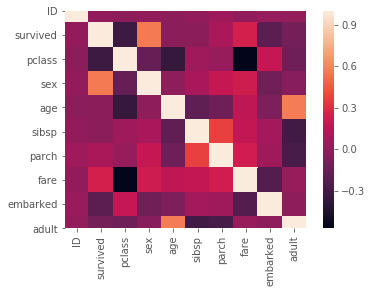

In [15]:
corr = input_data.corr()
sns.heatmap(corr, square=True)

## Rozdělení dat

In [16]:
seed = 666

Xdata = input_data.drop(columns = ['survived']) # data bez survived
ydata = input_data.survived # jen survived

display(Xdata.isnull().sum(axis=0))

#display(Xdata)
#display(ydata)

#classifier = DecisionTreeClassifier(max_depth=3)
#classifier.fit(Xdata, ydata)

# ze 3. cvičení
from sklearn.model_selection import train_test_split
def split_data(Xdata, ydata, ratio=0.25, rd_seed=seed):
    Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
    Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
    return Xtrain, Xtest, Xval, ytrain, ytest, yval

# vystupni data
Xtrain, Xtest, Xval, ytrain, ytest, yval = split_data(Xdata, ydata)

ID          0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
adult       0
dtype: int64

## Klasifikační model, nejlepší parameter

optimal params (train) {'max_depth': 17, 'criterion': 'entropy'}
optimal params (test) {'max_depth': 3, 'criterion': 'entropy'}
optimal params (val) {'max_depth': 2, 'criterion': 'entropy'}
accuracy score (train): 0.822064
accuracy score (test): 0.772000
accuracy score (val): 0.816777


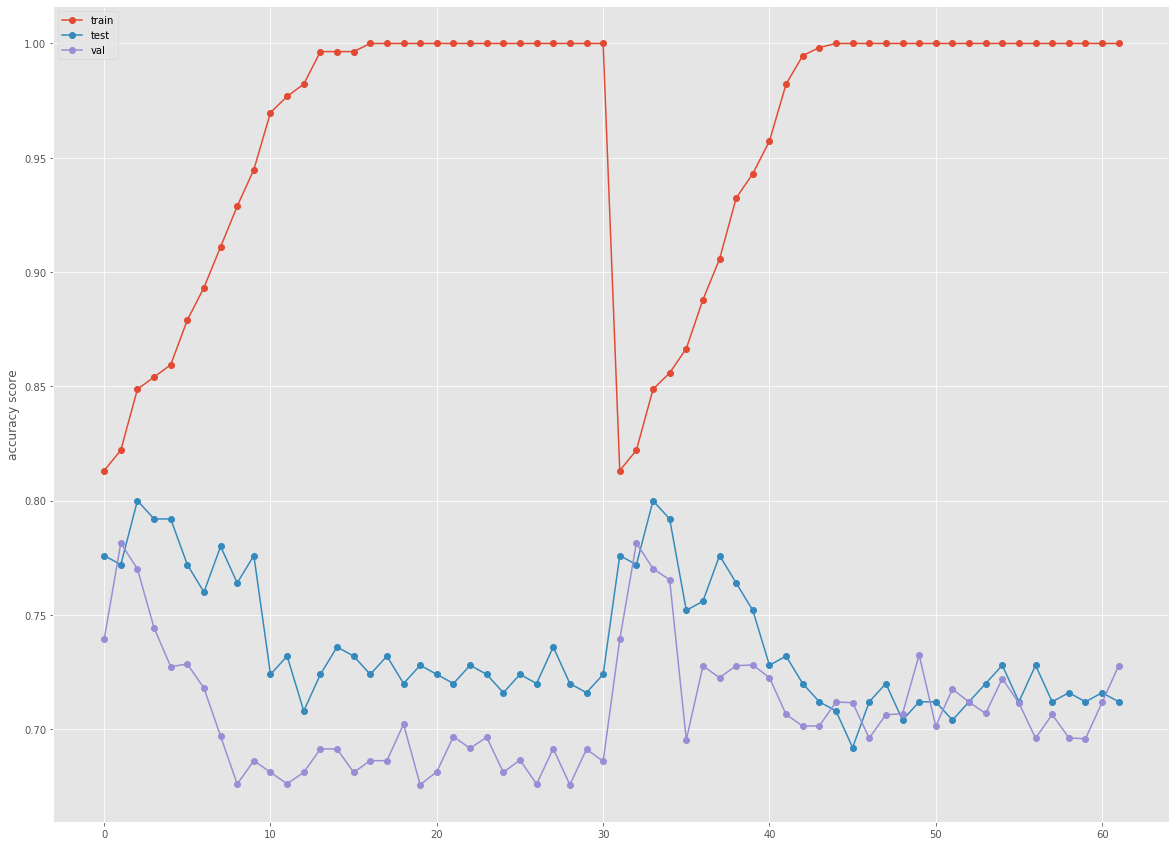

In [19]:
### NASTAVENÍ
parameter_grid = {
    'max_depth': range(1,32),
    'criterion': ['entropy', 'gini'],
}
parameter_comb = ParameterGrid(parameter_grid)

### TRÉNOVÁNÍ
train_accuracy = []
test_accuracy = []
val_accuracy = []
for params in parameter_comb:
    classifier = DecisionTreeClassifier(**params)
    classifier.fit(Xtrain, ytrain)
    train_accuracy.append(accuracy_score(ytrain, classifier.predict(Xtrain)))
    test_accuracy.append(accuracy_score(ytest, classifier.predict(Xtest)))
    #val_accuracy.append(accuracy_score(yval, classifier.predict(Xval)))
    val_accuracy.append(np.mean(cross_val_score(classifier, Xval, yval, cv = 5)))

### NEJLEPŠÍ PARAMETR etc.
print('optimal params (train)', parameter_comb[np.argmax(train_accuracy)])
print('optimal params (test)', parameter_comb[np.argmax(test_accuracy)])
print('optimal params (val)', parameter_comb[np.argmax(val_accuracy)])
best = parameter_comb[np.argmax(val_accuracy)] # podle val dat
classifier = DecisionTreeClassifier(**best)
classifier.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, classifier.predict(Xtrain))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, classifier.predict(Xtest))))
print('accuracy score (val): {0:.6f}'.format(np.mean(cross_val_score(classifier, Xtrain, ytrain, cv = 5))))

### GRAF
f = plt.figure(figsize = (20, 15))
plt.plot(train_accuracy, 'o-')
plt.plot(test_accuracy, 'o-')
plt.plot(val_accuracy, 'o-')
plt.ylabel("accuracy score")
plt.legend(["train", "test", "val"])

## Vyhodnocení

// Je nutné spustit po vyhodnocení předchozích buněk (kvůli odkazu na *best* parametry a *classifier*)

In [14]:
eval_data = pd.read_csv('evaluation.csv')
eval_data = modify_data(eval_data)
display(eval_data)

fare mean 32.229381229773466
age mean male 32.486111111111114
age mean female 25.423529411764704


,ID,pclass,sex,age,sibsp,parch,fare,embarked,adult
0,1000,1,0,13.000000,2,2,262.3750,0,0
1,1001,3,0,36.000000,0,0,7.4958,2,1
2,1002,3,0,32.486111,0,0,7.7500,1,1
3,1003,3,0,32.486111,0,0,7.2250,0,1
4,1004,3,0,36.000000,0,0,9.5000,2,1
5,1005,1,0,37.000000,0,1,29.7000,0,1
6,1006,3,1,16.000000,0,0,7.6500,2,0
7,1007,1,0,36.000000,0,0,26.2875,2,1
8,1008,3,1,25.423529,8,2,69.5500,2,1
9,1009,1,0,32.486111,0,0,30.6958,0,1


In [15]:
# predikce
eval_data['survived'] = classifier.predict(eval_data)
display(eval_data)
# zápis
eval_data[['ID', 'survived']].to_csv('results.csv')

,ID,pclass,sex,age,sibsp,parch,fare,embarked,adult,survived
0,1000,1,0,13.000000,2,2,262.3750,0,0,0
1,1001,3,0,36.000000,0,0,7.4958,2,1,0
2,1002,3,0,32.486111,0,0,7.7500,1,1,0
3,1003,3,0,32.486111,0,0,7.2250,0,1,0
4,1004,3,0,36.000000,0,0,9.5000,2,1,0
5,1005,1,0,37.000000,0,1,29.7000,0,1,0
6,1006,3,1,16.000000,0,0,7.6500,2,0,1
7,1007,1,0,36.000000,0,0,26.2875,2,1,0
8,1008,3,1,25.423529,8,2,69.5500,2,1,1
9,1009,1,0,32.486111,0,0,30.6958,0,1,0
